In [ ]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.stem.porter import *
import string
import re
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
!pip install textstat
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.0 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("labeled_data.csv")
df.head(10)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [ ]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [ ]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

<Axes: >

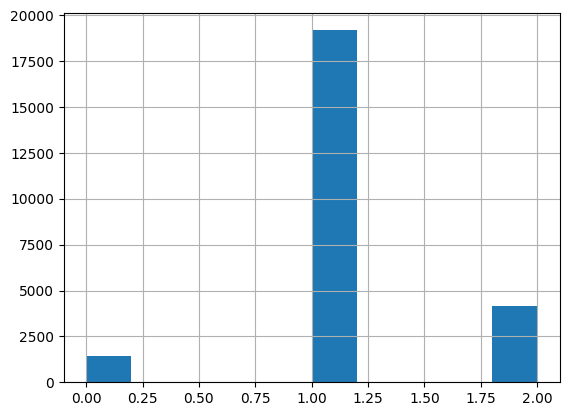

In [ ]:
df['class'].hist()

In [ ]:
tweets=df.tweet
max_length = max(len(tweet) for tweet in tweets)
print(max_length)
min_length = min(len(tweet) for tweet in tweets)
print(min_length)

754
5


In [ ]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    spaces = '\s+'
    url = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
      '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention = '@[\w\-]+'
    text = re.sub(spaces, ' ', text_string)
    text = re.sub(url, '', text)
    text = re.sub(mention, '', text)
    return text

def tokenize(tweet):
  """Removes punctuation & excess whitespace, sets to lowercase,
  and stems tweets. Returns a list of stemmed tokens."""
  tweet = " ".join(re.split("[^a-zA-Z]+", tweet.lower())).strip()
  tokens = [stemmer.stem(t) for t in tweet.split() if t]
  return tokens

def basic_tokenize(tweet):
    """Tokenize tweet by removing punctuation and returning words only (no stemming)."""

    # Convert tweet to lowercase
    tweet = tweet.lower()

    # Use regular expression to retain only alphabetic words (remove punctuation)
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)  # Remove all non-alphabetic characters (keep spaces)

    # Split the cleaned-up tweet into words (tokens)
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )
vectorizer


TfidfVectorizer(decode_error='replace', max_df=0.75, max_features=10000,
                min_df=5, ngram_range=(1, 3), norm=None,
                preprocessor=<function preprocess at 0x7aa79eebade0>,
                smooth_idf=False,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenize at 0x7aa79eebaa20>)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
print("tfidf values=")
print(tfidf)
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
print("vocab(word to index mapping)")
print(vocab)
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores
print("idf scores")
print(idf_dict)
tfidfmatrix= pd.DataFrame(tfidf, columns=vectorizer.get_feature_names_out())
print("tfidfmatrix=")
print(tfidfmatrix)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


tfidf values=
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
vocab(word to index mapping)
{'ab': 0, 'abil': 1, 'abl': 2, 'abo': 3, 'abort': 4, 'abov': 5, 'absolut': 6, 'abt': 7, 'abu': 8, 'abus': 9, 'accent': 10, 'accept': 11, 'accid': 12, 'accident': 13, 'accord': 14, 'account': 15, 'accur': 16, 'acknowledg': 17, 'across': 18, 'act': 19, 'act like': 20, 'act like bitch': 21, 'act like hoe': 22, 'act like pussi': 23, 'actin': 24, 'actin like': 25, 'action': 26, 'activ': 27, 'actor': 28, 'actual': 29, 'actual fuck': 30, 'ad': 31, 'adam': 32, 'add': 33, 'addict': 34, 'address': 35, 'admit': 36, 'adopt': 37, 'ador': 38, 'adult': 39, 'advanc': 40, 'advic': 41, 'ae': 42, 'af': 43, 'affect': 44, 'afford': 45, 'afraid': 46, 'african': 47, 'afterward': 48, 'ag': 49, 'age': 50, 'ago': 51, 'agre': 52, 'ah': 53, 'ah bitch': 54, 'aha': 55, 'ahaha': 56, 'ahead': 57, 'ahh': 58, 'ahhh': 59, 'a

In [ ]:
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)


In [ ]:
print(tweet_tags[0])

NN IN DT NN PRP VBP VB IN VBG RP PRP$ NN NN IN DT NN PRP MD RB VB DT NN RP


In [ ]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=4000,
    min_df=5,
    max_df=0.75,
    )

In [ ]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
print("pos tfidf values=")
print(tfidf)
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}
print("pos vocab(word to index mapping)")
print(pos_vocab)


pos tfidf values=
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
pos vocab(word to index mapping)
{'CC': 0, 'CC CC': 1, 'CC CD': 2, 'CC CD NN': 3, 'CC CD NNS': 4, 'CC DT': 5, 'CC DT CC': 6, 'CC DT IN': 7, 'CC DT JJ': 8, 'CC DT NN': 9, 'CC DT NNS': 10, 'CC DT PRP': 11, 'CC DT RB': 12, 'CC DT VBD': 13, 'CC DT VBP': 14, 'CC EX': 15, 'CC IN': 16, 'CC IN DT': 17, 'CC IN JJ': 18, 'CC IN NN': 19, 'CC IN NNS': 20, 'CC IN PRP': 21, 'CC IN VBN': 22, 'CC IN VBP': 23, 'CC JJ': 24, 'CC JJ CC': 25, 'CC JJ DT': 26, 'CC JJ IN': 27, 'CC JJ JJ': 28, 'CC JJ MD': 29, 'CC JJ NN': 30, 'CC JJ NNS': 31, 'CC JJ PRP': 32, 'CC JJ RB': 33, 'CC JJ TO': 34, 'CC JJ VB': 35, 'CC JJ VBD': 36, 'CC JJ VBG': 37, 'CC JJ VBN': 38, 'CC JJ VBP': 39, 'CC JJ VBZ': 40, 'CC JJR': 41, 'CC JJS': 42, 'CC MD': 43, 'CC MD RB': 44, 'CC MD VB': 45, 'CC NN': 46, 'CC NN CC': 47, 'CC NN DT': 48, 'CC NN IN': 49, 'CC NN JJ': 50, 'CC 

In [ ]:
!pip install better-profanity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.7 MB/s eta 0:00:00


In [ ]:
import re
import pandas as pd
from better_profanity import profanity

# Load custom profanity words into better_profanity
custom_profanity_list = [
    "nigga", "nigger", "fuck", "shit", "bitch", "cunt", "asshole",
    "fucking", "motherfucker", "dumbass", "slut", "whore", "cock",
    "dick", "pussy", "fag", "faggot", "retard", "bastard", "twat"
]
profanity.load_censor_words(custom_profanity_list)

# **1️⃣ Normalize text to detect obfuscation**
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[\W_]+', '', text)  # Remove symbols like @, *, _
    text = re.sub(r'\s+', '', text)  # Remove spaces between characters
    return text

# **2️⃣ Check if text contains profanity (Even Obfuscated)**
def contains_profanity(text):
    normalized_text = normalize_text(text)
    return int(any(word in normalized_text for word in custom_profanity_list))


# **4️⃣ Detect Obfuscation with Regex**
obfuscation_patterns = [
    r'f[\W_]*u[\W_]*c[\W_]*k',
    r's[\W_]*h[\W_]*i[\W_]*t',
    r'b[\W_]*i[\W_]*t[\W_]*c[\W_]*h',
    r'n[\W_]*i[\W_]*g[\W_]*g[\W_]*a',
    r'p[\W_]*u[\W_]*s[\W_]*s[\W_]*y',
    r'n[\W_]*i[\W_]*g[\W_]*g[\W_]*e[\W_]*r',
    r'f[\W_]*a[\W_]*g',
    r'f[\W_]*a[\W_]*g[\W_]*g[\W_]*o[\W_]*t'
]
compiled_patterns = [re.compile(pattern, re.IGNORECASE) for pattern in obfuscation_patterns]

def detect_obfuscation(text):
    return int(any(pattern.search(text) for pattern in compiled_patterns))

# **5️⃣ Return All Three Profanity Scores**
def get_profanity_scores(text):
    return [contains_profanity(text),detect_obfuscation(text)]



In [ ]:
import spacy

# Load Spacy English model
nlp = spacy.load('en_core_web_sm')

def extract_dependency_tuples(tweet):
    """
    Extract dependency tuples (governor, dependency, dependent) from the tweet.
    Returns a list of tuples for the given tweet.
    """
    doc = nlp(tweet)
    dep_tuples = [(token.head.text, token.dep_, token.text) for token in doc]
    return dep_tuples


In [ ]:
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.

    Returns counts of urls, mentions, and hashtags.
    """
    spaces = '\s+'
    giant_url = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention = '@[\w\-]+'
    hashtag = '#[\w\-]+'
    text = re.sub(spaces, ' ', text_string)
    text = re.sub(giant_url, 'URLHERE', text)
    text = re.sub(mention, 'MENTIONHERE', text)
    text = re.sub(hashtag, 'HASHTAGHERE', text)
    return(text.count('URLHERE'),text.count('MENTIONHERE'),text.count('HASHTAGHERE'))

# NER Feature Extraction
def ner_features(tweet):
    """
    Extracts named entity recognition (NER) features from a tweet.
    Returns counts of different entity types.
    """
    doc = nlp(tweet)
    ner_counts = {}
    for ent in doc.ents:
        if ent.label_ in ner_counts:
            ner_counts[ent.label_] += 1
        else:
            ner_counts[ent.label_] = 1

    # Get a fixed list of common entity types and ensure all are represented
    common_entity_types = [
        'PERSON', 'NORP', 'FAC', 'ORG',  'LOC',
        'DATE'
    ]
    features = [ner_counts.get(entity, 0) for entity in common_entity_types]
    return features

# Update other_features function to include NER
def other_features(tweet):
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    words = preprocess(tweet)  # Get text only
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables + 0.001)) / float(num_words + 0.001), 4)
    num_unique_terms = len(set(words.split()))

    # Extract dependency tuples
    dep_tuples = extract_dependency_tuples(tweet)
    dep_types = [dep[1] for dep in dep_tuples]  # Extract dependency types
    dep_count = {dep: dep_types.count(dep) for dep in set(dep_types)}

    # Example: Include counts of specific dependency relations
    nsubj_count = dep_count.get('nsubj', 0)
    dobj_count = dep_count.get('dobj', 0)

    # Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words) / 1.0) + float(11.8 * avg_syl) - 15.59, 1)
    FRE = round(206.835 - 1.015 * (float(num_words) / 1.0) - (84.6 * float(avg_syl)), 2)

    twitter_objs = count_twitter_objs(tweet)

    # Get NER features
    ner_feats = ner_features(tweet)
    prof_scores= get_profanity_scores(tweet)

    features = [
        FKRA, FRE, syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
        num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
        twitter_objs[2], twitter_objs[1], twitter_objs[0],
        nsubj_count, dobj_count
    ] + ner_feats + prof_scores  # Append NER features
    return features

def get_feature_array(tweets):
  feats = []
  for t in tweets:
      feats.append(other_features(t))
  return np.array(feats)


In [ ]:
other_features_names = [
    "FKRA", "FRE", "num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total",
    "num_terms", "num_words", "num_unique_words", "vader neg", "vader pos", "vader neu",
    "vader compound", "num_hashtags", "num_mentions", "num_urls",
    "nsubj_count", "dobj_count"
] + [
    'PERSON', 'NORP', 'FAC', 'ORG', 'LOC','DATE'
]+["profanity_present", "obfuscated_profanity"]


In [ ]:
feats = get_feature_array(tweets)
feats.shape
#print(feats)

(24783, 26)

In [ ]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [ ]:
M.shape
#print(M)

(24783, 11112)

In [ ]:

#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names
print(feature_names)

['ab', 'abil', 'abl', 'abo', 'abort', 'abov', 'absolut', 'abt', 'abu', 'abus', 'accent', 'accept', 'accid', 'accident', 'accord', 'account', 'accur', 'acknowledg', 'across', 'act', 'act like', 'act like bitch', 'act like hoe', 'act like pussi', 'actin', 'actin like', 'action', 'activ', 'actor', 'actual', 'actual fuck', 'ad', 'adam', 'add', 'addict', 'address', 'admit', 'adopt', 'ador', 'adult', 'advanc', 'advic', 'ae', 'af', 'affect', 'afford', 'afraid', 'african', 'afterward', 'ag', 'age', 'ago', 'agre', 'ah', 'ah bitch', 'aha', 'ahaha', 'ahead', 'ahh', 'ahhh', 'aid', 'aim', 'ainn', 'aint', 'aint bitch', 'aint even', 'aint fuck', 'aint fuckin', 'aint get', 'aint got', 'aint hoe', 'aint hoe get', 'aint loyal', 'aint never', 'aint nobodi', 'aint noth', 'aint shit', 'aint shit bitch', 'air', 'aka', 'al', 'al qaeda', 'alabama', 'alarm', 'albino', 'album', 'alcohol', 'alert', 'alex', 'alex smith', 'alien', 'alik', 'aliv', 'allah', 'allen', 'allow', 'almost', 'almost got', 'alon', 'along', 

In [ ]:
# Assuming the dataset is stored in a pandas DataFrame `df`
# and the target column is named 'class'

# Count the number of tweets in each category
tweet_counts = df['class'].value_counts()

# Map numeric labels to class names (if applicable)
class_mapping = {0: "Hate", 1: "Offensive", 2: "No hate No Offense"}
tweet_counts_named = tweet_counts.rename(index=class_mapping)

# Print the counts
print("Number of tweets per category:")
print(tweet_counts_named)

# Access specific counts
hate_tweets = tweet_counts[0]
offensive_tweets = tweet_counts[1]

print(f"\nNumber of 'Hate' tweets: {hate_tweets}")
print(f"Number of 'Offensive' tweets: {offensive_tweets}")

Number of tweets per category:
class
Offensive             19190
No hate No Offense     4163
Hate                   1430
Name: count, dtype: int64

Number of 'Hate' tweets: 1430
Number of 'Offensive' tweets: 19190


In [ ]:
X = pd.DataFrame(M)
y = df['class'].astype(int)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(C=0.001, penalty='l2', solver='lbfgs', class_weight='balanced', max_iter=500))
])

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_preds = pipeline.predict(X_test)



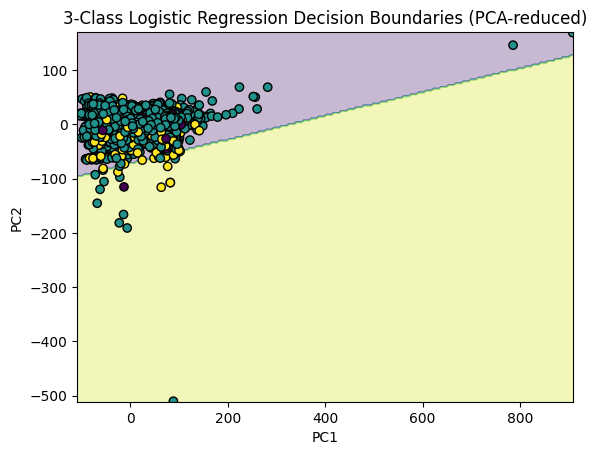

In [ ]:
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_test)

# Retrain a logistic regression on the reduced data
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
clf.fit(X_vis, y_test)

# Plot decision boundaries
import numpy as np

x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_test, edgecolor='k')
plt.title("3-Class Logistic Regression Decision Boundaries (PCA-reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


F1 Score: 0.8684
Accuracy: 0.8604
AUC Score: 0.9139


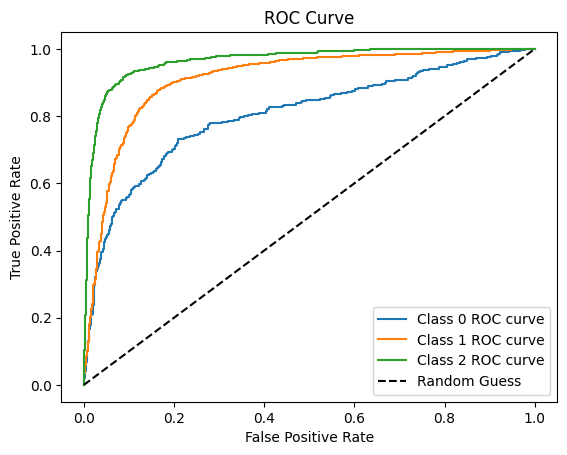

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve
y_probs = pipeline.predict_proba(X_test)  # For models like LogisticRegression, RandomForest, etc.

def calculate_metrics(y_test, y_preds, y_probs=None, average='weighted', plot_roc=True):
    # Calculate metrics
    f1 = f1_score(y_test, y_preds, average=average)
    acc = accuracy_score(y_test, y_preds)

    # Print metrics
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {acc:.4f}")

    # Calculate and print AUC if probabilities are provided
    if y_probs is not None:
        auc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=average)
        print(f"AUC Score: {auc:.4f}")

        if plot_roc:
            # Plot ROC Curve for each class
            n_classes = len(set(y_test))  # Number of classes
            fpr = {}
            tpr = {}
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test == i, y_probs[:, i])
                plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve')

            plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
            plt.title("ROC Curve")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend()
            plt.show()

calculate_metrics(y_test, y_preds, y_probs=y_probs, average='weighted', plot_roc=True)


In [ ]:
report = classification_report( y_test, y_preds )
print(report)

              precision    recall  f1-score   support

           0       0.33      0.48      0.39       290
           1       0.94      0.89      0.92      3832
           2       0.78      0.86      0.82       835

    accuracy                           0.86      4957
   macro avg       0.68      0.74      0.71      4957
weighted avg       0.88      0.86      0.87      4957



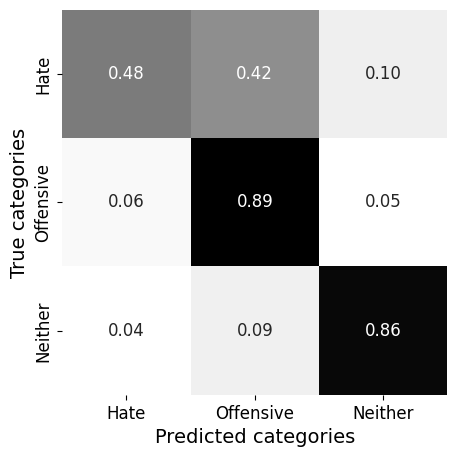

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

<Axes: >

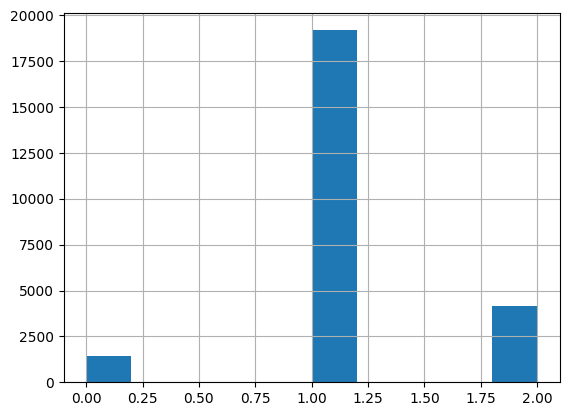

In [ ]:
#True distribution
y.hist()


<Axes: >

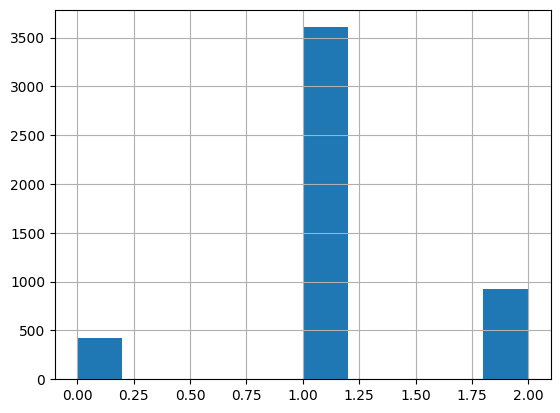

In [ ]:
pd.Series(y_preds).hist()

In [ ]:
# Define a mapping function for class labels
def class_to_name(class_number):
    classes = {0: "Hate", 1: "Offensive", 2: "Neither"}
    return classes.get(class_number, "Unknown")
    # hi, #i hate you, #this city is full of white trash, #people like you ruin everything

# Define the prediction function
def get_tweets_predictions(tweets):
    # Preprocess and vectorize the tweet as you did with the training data
    tfidf_tweets = vectorizer.transform(tweets).toarray()

    # POS tagging
    tweet_tags = []
    for t in tweets:
        tokens = basic_tokenize(preprocess(t))
        tags = nltk.pos_tag(tokens)
        tag_list = [x[1] for x in tags]
        tag_str = " ".join(tag_list)
        tweet_tags.append(tag_str)

    pos_tags = pos_vectorizer.transform(pd.Series(tweet_tags)).toarray()

    # Extract other features
    other_feats = get_feature_array(tweets)

    # Concatenate all features
    tweet_features = np.concatenate([tfidf_tweets, pos_tags, other_feats], axis=1)

    # Predict using the trained pipeline model
    prediction = pipeline.predict(tweet_features)
    return prediction

# Testing the code
if __name__ == '__main__':
    print("Enter a tweet to classify:")

    # Get a tweet from user input
    custom_tweet = input("Enter your tweet: ")

    # Ensure the input is in list form as required by the function
    tweet_to_test = [custom_tweet]

    print("Predicting for the given tweet...")

    # Call the prediction function on this single tweet
    prediction = get_tweets_predictions(tweet_to_test)

    # Display the result
    print("\nTweet:")
    print(custom_tweet)
    print("Predicted Class:", class_to_name(prediction[0]))  # Convert class number to class name


Enter a tweet to classify:


KeyboardInterrupt: Interrupted by user

In [ ]:
import pickle

# Save cheyyadam
with open('pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open('pos_vectorizer.pkl', 'wb') as f:
    pickle.dump(pos_vectorizer, f)

# Download cheskovadam
from google.colab import files
files.download('pipeline.pkl')
files.download('vectorizer.pkl')
files.download('pos_vectorizer.pkl')